# <center> MUSIC INFORMATION RETRIEVAL</center>
## <center>Sound classification - deep-learning pipeline</center>    
### End-to-end classification using deep learning on the mel-spectrogram


### About this notebook

We will explore sound classification addressing the task of [Mridangam](https://en.wikipedia.org/wiki/Mridangam) stroke type classification. To do that, we will apply a deep-learning approach from the **mel-spectrogram** representation. 

**Note**: *this notebook is based on Marius Miron class materials.*

### How to run the notebook
You can download the notebook and run it locally in your computer.

You can also run it in Google Colab by using the following link.

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/mir_course/blob/main/notebooks/MIR_course-sound_classification_deep_learning_mel-spectrogram.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup environment

### Installation of packages

First of all we need to find out if the notebook is run on Colab and, if so, what version of cuda we have on the server. 

In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
  !nvcc -V

Then we install the pytorch version for the corresponding cuda version and the other packages.

In [ ]:
# !pip install torch torchaudio # Removed torch vision as it's not needed
!pip install torchaudio
!pip install torchmetrics # https://lightning.ai/docs/torchmetrics/stable/#install-torchmetrics
!pip install lightning
!pip install mirdata scikit-learn

In [ ]:
!pip install torch torchaudio --index-url https://download.pytorch.org/whl/cpu

In [19]:
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.6 MB/s  0:00:00 eta 0:00:01


### Import packages

We import the packages and we set the random_seed for our experiments. The random seed makes sure the experiment is reproducible on this environment.

We use mirdata to load the datasets, sklearn for data partitioning, torchaudio to load and transform audio files, and pytorch lightning on top of pytorch for machine learning. 

In [ ]:
import mirdata
import numpy as np
import sklearn
import matplotlib.pyplot as plt

# import sklearn.model_selection
# import random
import torch
import torchaudio
import lightning.pytorch as pl
import torchmetrics

# Set random seed for reproducibility
RANDOM_SEED=0
from lightning.pytorch import seed_everything
seed_everything(seed=RANDOM_SEED, workers=True)

Seed set to 0


0

## Data processing

We initialize Mridangam stroke a collection of 7162 audio examples of individual strokes of the Mridangam in various tonics. The dataset comprises of 10 different strokes played on Mridangams with 6 different tonic values. 

In this experiment we predict 10 stroke classes. 



In [2]:
mridangam = mirdata.initialize("mridangam_stroke")

First time the dataset needs to be downloaded. This is fairly easy with the public datasets in mirdata, by calling the download method. 

In [4]:
mridangam.download()

In [3]:
mridangam.validate()  # validate dataset

100%|██████████| 6976/6976 [00:00<00:00, 12980.25it/s]


({'tracks': {}}, {'tracks': {}})

### Inspect the data

In [4]:
import IPython.display as ipd
track = mridangam.choice_track()  # load a random track
x, sr = track.audio
ipd.Audio(track.audio_path)
print(track)  # see what data a track contains
ipd.Audio(x, rate=sr) # Listen to the audio

Track(
  audio_path="/home/am/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/E/231180__akshaylaya__thom-e-077.wav",
  stroke_name="thom",
  tonic="E",
  track_id="231180",
  audio: The track's audio

        Returns,
)


Let's have a look at the length of all the different files.

In [5]:
import numpy as np

# Get all track IDs
track_ids = mridangam.track_ids

# Initialize list to store durations
durations = []

# Loop through all tracks and get their durations
for track_id in track_ids:
  track = mridangam.track(track_id)
  metadata = torchaudio.info(track.audio_path)
  duration = metadata.num_frames / metadata.sample_rate
  durations.append(duration)

# Convert to numpy array for easy statistics
durations = np.array(durations)

print(f"Number of files: {len(durations)}")
print(f"Mean duration: {durations.mean():.3f} seconds")
print(f"Min duration: {durations.min():.3f} seconds")
print(f"Max duration: {durations.max():.3f} seconds")
print(f"Median duration: {np.median(durations):.3f} seconds")

/tmp/ipykernel_29318/2487761342.py:12: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  metadata = torchaudio.info(track.audio_path)
/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:20: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more 

Number of files: 6976
Mean duration: 0.353 seconds
Min duration: 0.023 seconds
Max duration: 2.344 seconds
Median duration: 0.313 seconds


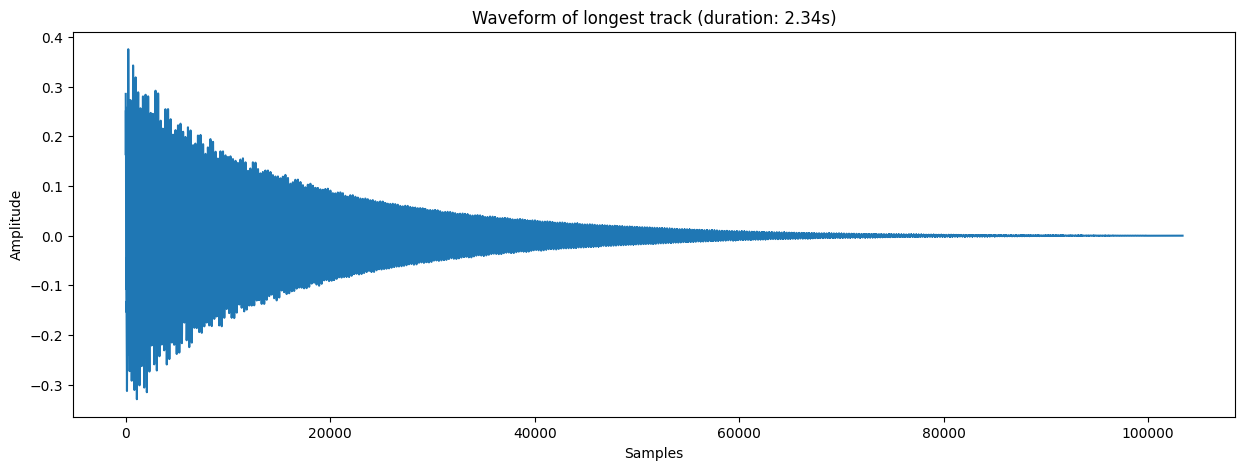

Track info:
Duration: 2.34s
Stroke name: bheem
Tonic: E


In [6]:
# Get the longest duration track
longest_idx = np.argmax(durations)
longest_track_id = track_ids[longest_idx]
longest_track = mridangam.track(longest_track_id)

# Load and display audio
x_long, sr_long = longest_track.audio

# Plot waveform
plt.figure(figsize=(15, 5))
plt.plot(x_long)
plt.title(f'Waveform of longest track (duration: {durations[longest_idx]:.2f}s)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

# Play the audio
ipd.Audio(x_long, rate=sr_long)

print(f"Track info:")
print(f"Duration: {durations[longest_idx]:.2f}s")
print(f"Stroke name: {longest_track.stroke_name}")
print(f"Tonic: {longest_track.tonic}")

In [8]:
ipd.Audio(x_long, rate=sr_long)


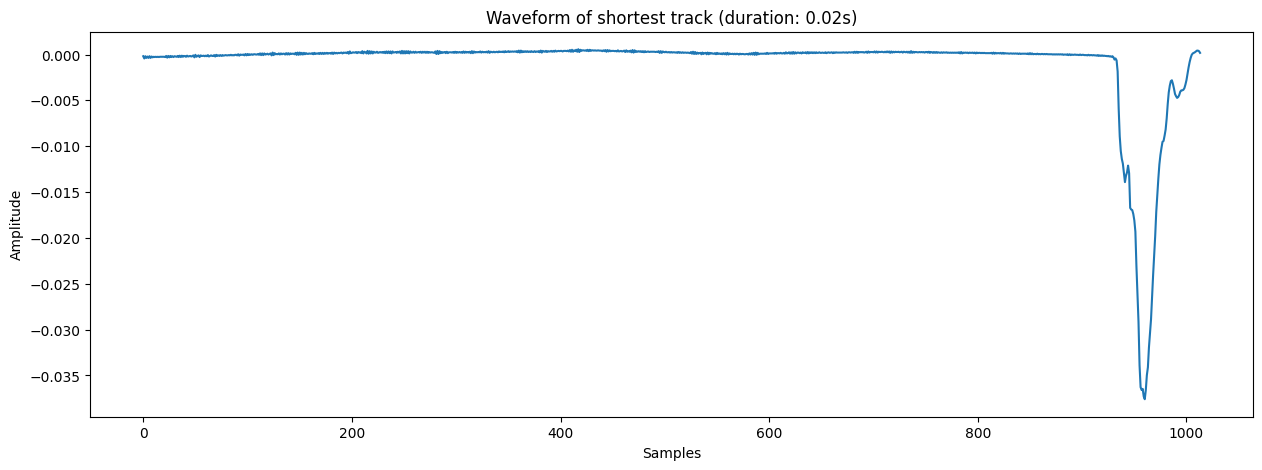

Track info:
Duration: 0.02s
Stroke name: thom
Tonic: D


In [9]:
# Get the shortest duration track
shortest_idx = np.argmin(durations)
shortest_track_id = track_ids[shortest_idx]
shortest_track = mridangam.track(shortest_track_id)

# Load and display audio
x_short, sr_short = shortest_track.audio

# Plot waveform
plt.figure(figsize=(15, 5))
plt.plot(x_short)
plt.title(f'Waveform of shortest track (duration: {durations[shortest_idx]:.2f}s)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

print(f"Track info:")
print(f"Duration: {durations[shortest_idx]:.2f}s")
print(f"Stroke name: {shortest_track.stroke_name}")
print(f"Tonic: {shortest_track.tonic}")

In [10]:
# Play the audio
ipd.Audio(x_short, rate=sr_short)

### Create PyTorch Dataset


In order to use this dataset with pytorch, we extend the Dataset object to load the audio and annotations in our dataset, according to these [instructions](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

We basically need to write three methods:


*   __init__
*   __len__
*   __getitem__ to return each pair of audio array and class label


This is how a prototype of this class could look like:

```
class MridangamDataset(torch.utils.data.Dataset):
    def __init__(self):
      self.track_ids = dataset.track_ids
    def __getitem__(self, index):
      # load data
      audio = load_audio(self.track_ids[index])
      label = self.track_ids[index].label
      # split audio in a fixed size array
      audio = audio[:seq_duration] 
      return audio,label
    def __len__(self):
      return len(self.tracks_ids)

```

For a good introduction to dataset loaders in the context of MIR see this tutorial [Deep Learning 101 for Audio based MIR](https://geoffroypeeters.github.io/deeplearning-101-audiomir_book/intro_pytorch.html)

Let's implement the class:



In [38]:
from torchcodec.decoders import AudioDecoder

class MridangamDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        mirdataset,
        seq_duration=0.5,
        random_start=True,
        resample=8000,
        subset=0,
        val_split = 0.1,
        test_split=0.1,
        random_seed=RANDOM_SEED
    ):
        self.seq_duration = seq_duration
        self.dataset = mirdataset
        self.track_ids = self.dataset.track_ids
        self.tracks = self.dataset.load_tracks()
        self.resample_rate = resample
        self.set = subset
        self.random_start = random_start

        # self.decoder = AudioDecoder()  # initialize once

        # Build a list with labels 
        labels = [self.dataset.track(i).stroke_name for i in self.track_ids]
        unique_labels = list(set(labels)) # unique labels
        self.labels = {label:i for i,label in enumerate(unique_labels)}

        # Build the three subsets: train, validation, test using train_test_split, a stratified split with the labels
  
        # First split off the test set
        self.trackids_trainval, self.trackids_test = sklearn.model_selection.train_test_split(
            self.track_ids,
            test_size=test_split,
            random_state=random_seed,
            stratify=labels
        )

        # Now split train/val from the remaining data
        trainval_labels = [l for l, i in zip(labels, self.track_ids) if i in self.trackids_trainval]
        
        # Compute val fraction of the remaining data
        val_frac = val_split / (1 - test_split)
        self.trackids_train, self.trackids_valid = sklearn.model_selection.train_test_split(
            self.trackids_trainval,
            test_size=val_frac,
            random_state=random_seed,
            stratify=trainval_labels
        )

    def __getitem__(self, index):
        if self.set == 0:
            track_id = self.trackids_train[index]
        elif self.set == 1:
            track_id = self.trackids_valid[index]
        else:
            track_id = self.trackids_test[index]

        track = self.dataset.track(track_id)

        # Load full signal to get metadata (simpler than torchaudio.info)
        
        decoder = AudioDecoder(source=track.audio_path, sample_rate=self.resample_rate)
        audio_signal = decoder.get_all_samples()
        sample_rate = decoder.metadata.sample_rate

        audio_signal = audio_signal.data
        # audio_signal, sample_rate = torchaudio.load(track.audio_path)
        channels, total_samples = audio_signal.shape
        duration = total_samples / sample_rate

        # Determine number of frames to extract
        num_frames = int(np.floor(self.seq_duration * sample_rate))
        if num_frames > total_samples:
            num_frames = total_samples

        # Optional random start
        offset = 0
        if self.random_start and num_frames < total_samples:
            max_offset = total_samples - num_frames
            offset = np.random.randint(0, max_offset)

        audio_segment = audio_signal[:, offset:offset + num_frames]

        # Zero pad if needed
        seq_duration_samples = int(self.seq_duration * sample_rate)
        pad_amount = seq_duration_samples - audio_segment.shape[-1]
        if pad_amount > 0:
            audio_segment = torch.nn.functional.pad(audio_segment, (0, pad_amount))

        # Resample TODO dont think this is needed anymore since decoder can resample
        if sample_rate != self.resample_rate:
            "resampling from {} to {}".format(sample_rate, self.resample_rate)
            audio_segment = torchaudio.transforms.Resample(sample_rate, self.resample_rate)(audio_segment)

        return audio_segment, self.labels[track.stroke_name]


    # def __getitem__(self, index):

    #     #### get the file with index in the corresponding subset
    #     if self.set == 0:
    #         track_id = self.trackids_train[index]
    #     elif self.set == 1:
    #         track_id = self.trackids_valid[index]
    #     elif self.set == 2:
    #         track_id = self.trackids_test[index]

    #     track = self.dataset.track(track_id)

    #     #### compute start and end frames to read from the disk
    #     # si, ei = torchaudio.info(track.audio_path)
    #     # sample_rate, channels, length = si.rate, si.channels, si.length
    #     ####alternative
    #     # metadata = torchaudio.info(track.audio_path)
    #     # sample_rate = metadata.sample_rate 
    #     # channels = metadata.num_channels
    #     # length = metadata.num_frames
    #     # duration = length / sample_rate

    #     audio_signal, sample_rate = torchaudio.load(track.audio_path)
    #     channels, total_samples = audio_signal.shape
    #     duration = total_samples / sample_rate


        
    #     offset = 0
    #     if self.seq_duration > duration:
    #         num_frames = length
    #     else:
    #         num_frames = int(np.floor(self.seq_duration * sample_rate))


    #     #### get audio frames corresponding to offset and num_frames from the disk
    #     audio_signal, sample_rate = torchaudio.load(uri=track.audio_path, frame_offset=offset,num_frames=num_frames)
    #     #### alternative
    #     #audio_signal, sample_rate = torchaudio.load(filepath=track.audio_path, offset=offset,num_frames=num_frames)

    #     #### zero pad if the size is smaller than seq_duration
    #     seq_duration_samples = int(self.seq_duration * sample_rate)
    #     total_samples = audio_signal.shape[-1]
    #     if seq_duration_samples>total_samples:
    #         audio_signal = torch.nn.ConstantPad2d((0,seq_duration_samples-total_samples,0,0),0)(audio_signal)

    #     #### resample
    #     audio_signal = torchaudio.transforms.Resample(sample_rate, self.resample)(audio_signal)

    #     return audio_signal, self.labels[track.stroke_name] 

    def __len__(self):
        if self.set == 0:
            return len(self.trackids_train)
        elif self.set == 1:
            return len(self.trackids_valid)
        else:
            return len(self.trackids_test)



In [ ]:
    # def __getitem__(self, index):
    #     # ...existing code to select track_id and get metadata...
    #     metadata = torchaudio.info(track.audio_path)
    #     sample_rate = metadata.sample_rate
    #     length = metadata.num_frames
    #     duration = length / sample_rate

    #     seq_samples = int(self.seq_duration * sample_rate)

    #     # --- Random start logic ---
    #     if self.seq_duration >= duration or not self.random_start:
    #         offset = 0
    #     else:
    #         max_offset = length - seq_samples
    #         offset = np.random.randint(0, max_offset + 1)  # +1 to include max_offset

    #     num_frames = min(seq_samples, length - offset)

    #     audio_signal, sample_rate = torchaudio.load(
    #         uri=track.audio_path, frame_offset=offset, num_frames=num_frames
    #     )

    #     # Zero pad if needed
    #     if audio_signal.shape[-1] < seq_samples:
    #         audio_signal = torch.nn.ConstantPad2d((0, seq_samples - audio_signal.shape[-1], 0, 0), 0)(audio_signal)

    #     audio_signal = torchaudio.transforms.Resample(sample_rate, self.resample)(audio_signal)

    #     return audio_signal, self.labels[track.stroke_name]

In [ ]:
# class MridangamDataset(torch.utils.data.Dataset):
#     def __init__(self, mirdataset, seq_duration=0.5, resample=8000, subset=0, random_seed=42):
#         self.seq_duration = seq_duration
#         self.dataset = mirdataset
#         self.resample_rate = resample
#         self.set = subset

#         # Label mapping
#         self.track_ids = self.dataset.track_ids
#         labels = [self.dataset.track(i).stroke_name for i in self.track_ids]
#         unique_labels = sorted(set(labels))
#         self.labels = {label: i for i, label in enumerate(unique_labels)}

#         # Train/val/test splits
#         self.trackids_train, self.trackids_test = sklearn.model_selection.train_test_split(
#             self.track_ids, train_size=0.8, random_state=random_seed, stratify=labels
#         )
#         train_labels = [l for l, i in zip(labels, self.track_ids) if i in self.trackids_train]
#         self.trackids_train, self.trackids_valid = sklearn.model_selection.train_test_split(
#             self.trackids_train, train_size=0.8, random_state=random_seed, stratify=train_labels
#         )

#         # Mel transform
#         self.mel_transform = torchaudio.transforms.MelSpectrogram(
#             sample_rate=resample,
#             n_fft=1024,
#             hop_length=256,
#             n_mels=64
#         )
#         self.db_transform = torchaudio.transforms.AmplitudeToDB()

#     def __getitem__(self, index):
#         # Select subset
#         track_id = {
#             0: self.trackids_train,
#             1: self.trackids_valid,
#             2: self.trackids_test
#         }[self.set][index]

#         track = self.dataset.track(track_id)
#         metadata = torchaudio.info(track.audio_path)
#         sample_rate = metadata.sample_rate

#         # Load audio
#         audio_signal, _ = torchaudio.load(track.audio_path)
#         if sample_rate != self.resample_rate:
#             audio_signal = torchaudio.transforms.Resample(sample_rate, self.resample_rate)(audio_signal)

#         # Pad/trim to fixed duration
#         target_len = int(self.seq_duration * self.resample_rate)
#         if audio_signal.shape[-1] > target_len:
#             audio_signal = audio_signal[..., :target_len]
#         else:
#             pad_len = target_len - audio_signal.shape[-1]
#             audio_signal = torch.nn.functional.pad(audio_signal, (0, pad_len))

#         # Compute mel spectrogram
#         mel = self.db_transform(self.mel_transform(audio_signal))

#         return mel, self.labels[track.stroke_name]

#     def __len__(self):
#         return len({0: self.trackids_train, 1: self.trackids_valid, 2: self.trackids_test}[self.set])


We initialize the dataset objects for train, validation, and test. We define the corresponding pytorch objects for data loading, defining the batch_size (paralellization on the GPU) and the num_workers ( data loading paralellization on CPU/memory).

In [39]:
#### Pytorch dataset loaders
train_dataset = MridangamDataset(mirdataset=mridangam, subset=0, random_seed=RANDOM_SEED)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=2, pin_memory=True)
valid_dataset = MridangamDataset(mirdataset=mridangam,subset=1, random_seed=RANDOM_SEED)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=64,num_workers=2, pin_memory=True)
test_dataset = MridangamDataset(mirdataset=mridangam,subset=2, random_seed=RANDOM_SEED)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64, num_workers=2, pin_memory=True)

Epoch 2:   9%|▉         | 8/88 [00:24<04:08,  0.32it/s, v_num=7]



**Which batch size/learning rate?**

Theory suggests that when multiplying the batch size by k, one should multiply the learning rate by sqrt(k) to keep the variance in the gradient expectation constant. See page 5 at A. Krizhevsky. One weird trick for parallelizing convolutional neural networks: https://arxiv.org/abs/1404.5997

However, recent experiments with large mini-batches suggest for a simpler linear scaling rule, i.e multiply your learning rate by k when using mini-batch size of kN. See P.Goyal et al.: Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour https://arxiv.org/abs/1706.02677

## Training a pytorch lightning classifier

We extend the pytorch lightning module according to the [documentation](https://lightning.ai/docs/pytorch/stable/model/train_model_basic.html). This may contain a definition of the layers in the neural network and how the data flows (how the layers are connected). You may overwrite other functions from `pl.LightningModule`, as described [here](https://lightning.ai/docs/pytorch/LTS/common/lightning_module.html). The most important are `training_step` and `configure_optimizers`, in which we define the training loss and the optimizers.

W = W - lr * Delta(W) -> Stochastic gradient descent
W = [w1 ... w10] [l1...l10] 

```
>>> class LitModel(pl.LightningModule):
...
...     def __init__(self):
...         super().__init__()
...         self.l1 = torch.nn.Linear(28 * 28, 10)
...
...     def forward(self, x):
...         return torch.relu(self.l1(x.view(x.size(0), -1)))
...
...     def training_step(self, batch, batch_idx):
...         x, y = batch
...         y_hat = self.forward(x)
...         loss = F.cross_entropy(y_hat, y)
...         return loss
...
...     def configure_optimizers(self):
...         return torch.optim.Adam(self.parameters(), lr=0.02)
```



We first build a Conv2D module which stacks several layers: 2D convolution, batch normalization, relu, maxpool, dropout

In [40]:
import torch.nn as nn

class ConvBlock(torch.nn.Module):
    def __init__(self, input_channels, output_channels, shape=3, pooling=2, dropout=0.1):
        super(ConvBlock, self).__init__()
        self .net = nn.Sequential( # We can use nn.Sequential to combine layers
            nn.Conv2d(input_channels, output_channels, shape, padding=shape//2),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(),
            nn.MaxPool2d(pooling),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.net(x) # Pass through all layers in sequence

We predict the 10 classes of the Mridangam stroke dataset with a CNN using as input the mel-spectrograms computed from audio files.

In [61]:
class CNN(pl.LightningModule):
    '''
    Simple CNN classification architecture: https://music-classification.github.io/tutorial/part3_supervised/tutorial.html
    '''
    def __init__(self, num_channels=16, 
                       sample_rate=8000, 
                       n_fft=1024, 
                       f_min=0.0, 
                       f_max=11025.0, 
                       num_mels=128, 
                       num_classes=10):
        super().__init__()
        
        # self.validation_step_outputs = []

        self.celoss = torch.nn.CrossEntropyLoss()

        # Front-end feature extraction: mel spectrogram
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, 
                                                            n_fft=n_fft, 
                                                            f_min=f_min, 
                                                            f_max=f_max, 
                                                            n_mels=num_mels)
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()
        self.input_bn = torch.nn.BatchNorm2d(1)

        # convolutional layers
        self.features = nn.Sequential(
            ConvBlock(1, num_channels, pooling=(2, 2)),
            ConvBlock(num_channels, num_channels, pooling=(2, 2)),
            ConvBlock(num_channels, num_channels * 2, pooling=(2, 2)),
            ConvBlock(num_channels * 2, num_channels * 2, pooling=(3, 1)),
            ConvBlock(num_channels * 2, num_channels * 4, pooling=(3, 1))
        )

        # classification head with dense layers
        self.classifier = nn.Sequential(
            nn.Linear(num_channels * 4, num_channels * 4),
            nn.BatchNorm1d(num_channels * 4),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(num_channels * 4, num_classes),
        )

        # Metrics
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.valid_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.test_cm = torchmetrics.classification.ConfusionMatrix(task='multiclass', num_classes=num_classes)

    def forward(self, wav):
        # calculate mel spectrogram on the fly, in the GPU if available
        with torch.no_grad():
            out = self.melspec(wav)
            out = self.amplitude_to_db(out)
        # input batch normalization
        # out = out.unsqueeze(1)
        out = self.input_bn(out)
        out = self.features(out)
        # reshape. (batch_size, num_channels, 1, 1) -> (batch_size, num_channels)
        # out = out.reshape(len(out), -1)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

    def _shared_step(self, batch, stage):
        waveform, label = batch
        logits = self.forward(waveform)
        loss = self.celoss(logits, label)
        preds = torch.argmax(logits, dim=1)
        metric = getattr(self, f"{stage}_acc")(preds, label)
        self.log(f"{stage}_loss", loss, on_step=False, on_epoch=True, prog_bar=(stage!="test"))
        self.log(f"{stage}_acc", metric, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, "valid")

    def test_step(self, batch, batch_idx):
        loss = self._shared_step(batch, "test")
        waveform, label = batch
        preds = torch.argmax(self(waveform), dim=1)
        self.test_cm.update(preds, label)
        return loss


    # def training_step(self, batch, batch_idx):
    #     waveform, label = batch
    #     logits = self.forward(waveform)
    #     loss = self.celoss(logits, label)
    #     preds = torch.argmax(logits, dim=1)

    #     acc = self.train_acc(preds, label)
    #     self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
    #     self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
    #     return loss


    # def validation_step(self, batch, batch_idx):
    #     waveform, label = batch
    #     logits = self.forward(waveform)
    #     loss = self.celoss(logits, label)
    #     self.log('val_loss', loss)
    #     _, pred = torch.max(logits, 1)
    #     # self.valid_acc(pred, label)
    #     # self.log('valid_acc', self.valid_acc, on_step=True, on_epoch=True)

    #     acc = self.valid_acc(pred, label)
    #     self.log('valid_acc', acc, on_step=True, on_epoch=True, prog_bar=True)

    # def test_step(self, batch, batch_idx):
    #     waveform, label = batch
    #     b, c, t = waveform.size()
    #     logits = self.forward(waveform)
    #     loss = self.celoss(logits, label)
    #     self.log('test_loss', loss)
    #     _, pred = torch.max(logits, 1)
    #     self.test_acc(pred, label)
    #     self.log('test_acc', self.test_acc, on_step=True, on_epoch=True)


    #     self.test_cm(pred, label)

    def get_progress_bar_dict(self):
        # don't show the version number
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        return items

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3,weight_decay=0.0001)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # reduce the learning after 10 epochs by a factor of 10
        # return [optimizer], [scheduler]

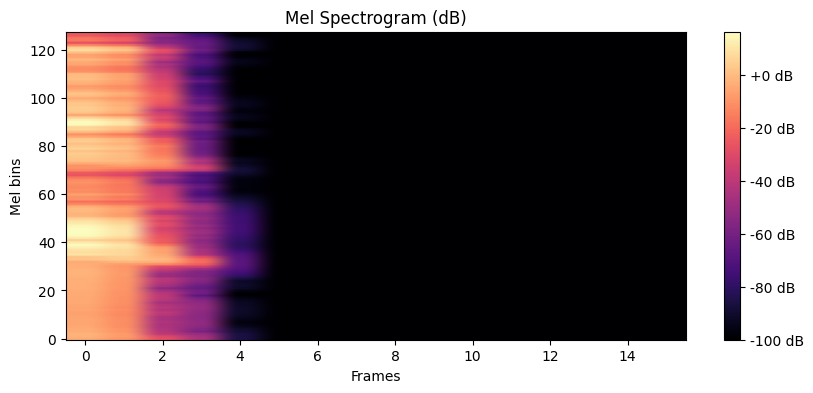

In [58]:
# Get a batch from the train_loader
batch = next(iter(train_loader))
waveform, label = batch  # waveform shape: (batch_size, channels, samples)

# Use the same mel-spectrogram transform as in model
melspec = torchaudio.transforms.MelSpectrogram(
    sample_rate=8000, n_fft=1024, hop_length=256, n_mels=128
)
amplitude_to_db = torchaudio.transforms.AmplitudeToDB()

# Compute mel spectrogram for the first sample in the batch
mel = melspec(waveform[0])
mel_db = amplitude_to_db(mel)

# Plot the mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_db.squeeze().cpu().numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title('Mel Spectrogram (dB)')
plt.xlabel('Frames')
plt.ylabel('Mel bins')
plt.colorbar(format='%+2.0f dB')
plt.show()

We train the model defined above.

In [69]:
#### Initialize the model
model = CNN()

#### Initialize a trainer
trainer = pl.Trainer(max_epochs=10, accelerator="auto")

#### Train the model
trainer.fit(model, train_loader, valid_loader)

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/functional/functional.py:585: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | celoss          | CrossEntropyLoss          | 0      | train
1 | melspec         | MelSpectrogram            | 0      | train
2 | amplitude_to_db | AmplitudeToDB             | 0      | train
3 | input_bn        | BatchNorm2d               | 2      | train
4 | features        | Sequential                | 35.2 K | train
5 | classifier      | Sequential                | 4.9 K  | train
6 | train_acc       | MulticlassAccuracy        | 0      | train
7 | valid_acc       | MulticlassAccuracy        | 0      | train
8 | test_acc        | MulticlassAccuracy        | 0      | train
9 | test_cm         | MulticlassConfusionMatrix | 0      | train
----------------------------------------------------------------------
40.1 K    Tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 9: 100%|██████████| 88/88 [00:09<00:00,  9.19it/s, v_num=0, valid_loss=0.333, valid_acc=0.880, train_loss=0.530, train_acc=0.805]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 88/88 [00:09<00:00,  9.18it/s, v_num=0, valid_loss=0.333, valid_acc=0.880, train_loss=0.530, train_acc=0.805]


Once the model is trained we can use it to process data, save it, get the metrics on the test set. 

In [70]:

#### Put the model in production
model.eval()

#### Compute metrics on the test set
trainer.test(dataloaders=test_loader)

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at /home/am/Documents/upf_smc/mir_materials_internship/mir_course/notebooks/lightning_logs/version_0/checkpoints/epoch=9-step=880.ckpt
INFO: Loaded model weights from the checkpoint at /home/am/Documents/upf_smc/mir_materials_internship/mir_course/notebooks/lightning_logs/version_0/checkpoints/epoch=9-step=880.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:01<00:00,  6.95it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8782234787940979     │
│         test_loss         │    0.3710367679595947     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3710367679595947, 'test_acc': 0.8782234787940979}]

In [71]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("lightning_logs", name="cnn_audio")
trainer = pl.Trainer(logger=logger)


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [ ]:
!tensorboard --logdir lightning_logs

2025-10-10 11:17:24.103995: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-10 11:17:24.104425: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-10 11:17:24.141253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-10 11:17:25.372867: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

## Error Analysis

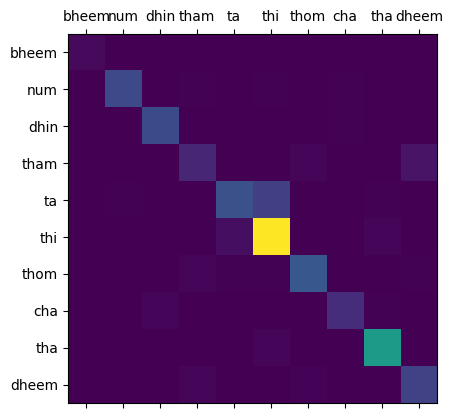

In [64]:
#### Compute confusion matrix on the test set
confusion_matrix = model.test_cm.compute().cpu().numpy()
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.matshow(confusion_matrix)
ax.set_xticks(range(len(train_dataset.labels)))
ax.set_yticks(range(len(train_dataset.labels)))
ax.set_xticklabels(train_dataset.labels)
ax.set_yticklabels(train_dataset.labels)
plt.show()

## 💭 Questions

---

- Do different representations of audio improve performance?
  - You might explore different embeddings (VGGish, EnCodec) etc.

## 💡 Possible Extensions
---
  